<a href="https://colab.research.google.com/github/alexmjn/NBA-Injuries/blob/master/NBA_Injuries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NBA Injuries

*The unpredictable nature of injuries costs NBA teams millions of dollars each year (in addition to the cost in human suffering)*. I want to explore the patterns of injury and rest in the NBA. Have injury rates risen as the NBA has gotten more physically taxing? Did the 2011 NBA lockout affect injury rates for that season? Do different teams have different patterns of rest and injury? Using the NBA's published injury reports (sourced from Kaggle), I investigate these questions. 


#Import Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, ttest_1samp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [0]:
url = "https://raw.githubusercontent.com/alexmjn/NBA-Injuries/master/injuries.csv"
injuries = pd.read_csv(url)

In [82]:
print(injuries.dtypes)
injuries.head()

Date           object
Team           object
Acquired       object
Relinquised    object
Notes          object
dtype: object


,Date,Team,Acquired,Relinquised,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Pendergraph / Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


#Cleaning Data

The data contains four columns we're interested in: "Date," "Team," "Relinquised," (a column that shows what player suffered the injury), and "Notes," which is a brief text description of the injury.

"Acquired" is used to denote rows where a player returned from injury. Though there is likely interesting analysis to be done on players' time of recovery, from scanning the data, the "Acquired" columns were reported inconsistently within seasons and for various types of injuries; thus, this data is out of the scope of this analysis.

Therefore I drop rows which represent a return from injury and not an injury or rest and then drop the column itself.

In [83]:
injuries.columns = injuries.columns.str.lower()
injuries = injuries[injuries["acquired"].isnull() == True]
injuries = injuries.drop(["acquired"], axis = 1)
injuries.shape

(8194, 4)

In [84]:
injuries.dtypes

date           object
team           object
relinquised    object
notes          object
dtype: object

To perform operations on the "date" column, I cast it as a datetime object. To prevent mismatches due to case-sensitivity, I make all 'notes' lowercase. Finally, I clean the column name.

In [85]:
injuries["date"] = pd.to_datetime(injuries["date"], infer_datetime_format = True)
injuries["notes"] = injuries["notes"].apply(str.lower)
injuries = injuries.rename(columns={"relinquised":"player"})
injuries.head()

,date,team,player,notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right acchilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Pendergraph / Jeff Ayres,torn acl in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


Rest is inconsistently logged as either "DNP" or "Rest (DNP)". To ensure consistency, I log each as the former.

In [0]:
injuries["notes"] = injuries["notes"].replace({"dnp":"rest (dnp)"})

In [87]:
injuries["notes"].value_counts().head()

sprained left ankle (dnp)     362
rest (dtd)                    288
rest (dnp)                    191
sprained right ankle (dnp)    175
illness (dtd)                 149
Name: notes, dtype: int64

It's interesting that sprained left ankles are so much more common than sprained right ankles. I'm assuming this has something to do with biomechanics of right-footed players. Anyway, it's clear this is not perfect -- rest is logged as two different things -- but, since this column is for feature engineering, we don't have to worry about exact matches as long as they contain the right word. 

In [88]:
injuries.isnull().sum()

date      0
team      3
player    0
notes     0
dtype: int64

In [89]:
injuries[injuries["team"].isnull() == True]

,date,team,player,notes
6330,2015-09-02,NaN,Glen Davis,surgery on left ankle to repair torn ligaments...
6332,2015-09-03,NaN,Landry Fields,surgery on hip to repair torn labrum (out inde...
8349,2017-02-08,NaN,Dragan Bender,surgery on right ankle to remove bone spur (ou...


From research, I see that the NaN values here represent when a player had surgery while he was not under contract with a team (a free agent or had been waived). So I replace the missing values with "None".

In [0]:
injuries["team"] = injuries["team"].replace({np.NaN: "None"})

In [91]:
print(injuries.dtypes)
injuries.isnull().sum()

date      datetime64[ns]
team              object
player            object
notes             object
dtype: object


date      0
team      0
player    0
notes     0
dtype: int64

One issue with this dataset is the inconsistent logging of injuries over multiple days. For minor injuries, players will show up on the injury report for the same injury over multiple days or even weeks. However, for major injuries, the injury will be reported once and the player's absence will be assumed (they will be placed on the inactive list).

To ensure consistency, I decide that every row representing an injury will represent a discrete player injury. To do this, I sort the data by player and date and remove rows where the same player has the same injury reported within ten days of the last report. 

In [92]:
injuries = injuries.sort_values(by = ["player", "date"])
injuries.head()

,date,team,player,notes
501,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
630,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
777,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
1379,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
1645,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)


In [0]:
# reset index for clean subsetting
injuries = injuries.reset_index(drop = True)

In [0]:
def same_player(df, i):
  return (df["player"][i] == df["player"][i-1])

def same_injury(df, i):
  return (df["notes"][i] == df["notes"][i-1])

def within_cutoff(df, i):
  return ((df["date"][i] - df["date"][i - 1]).days < 10)

def injury(df, i):
  return (("rest" in df["notes"][i]) == False)

In [0]:
def clean_injuries(df):
  redundant_rows = []

  for i in range(1, df.shape[0]):
    if same_player(df, i) & same_injury(df, i) & within_cutoff(df, i) & injury(df, i):
      redundant_rows.append(i)

  df = df.drop(redundant_rows)
  df = df.reset_index(drop = True)

  return df


In [96]:
injuries = clean_injuries(injuries)
print(injuries.shape)
injuries.head()

(5482, 4)


,date,team,player,notes
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely)
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp)
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp)
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp)
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp)


Looks like we got rid of the redundant injuries! Now every row represents (approximately) either a discrete injury or a voluntary day of rest. 

#Feature Engineering

Now that the data set is cleaned, it's time to engineer some features so that we can analyze the data. I'll start by adding features that represent which month of the season and year each injury occured. Then I'll use the season beginning and ending dates to place each injury within a particular season. 

In [0]:
injuries["month"] = (injuries["date"].dt.month - 9) % 12 
injuries["year"] = injuries["date"].dt.year

In [0]:
start_2011 = pd.Timestamp(2010, 10, 25, 12)
start_2012 = pd.Timestamp(2011, 12, 24, 12)
start_2013 = pd.Timestamp(2012, 10, 29, 12)
start_2014 = pd.Timestamp(2013, 10, 28, 12)
start_2015 = pd.Timestamp(2014, 10, 27, 12)
start_2016 = pd.Timestamp(2015, 10, 26, 12)
start_2017 = pd.Timestamp(2016, 10, 24, 12)
start_2018 = pd.Timestamp(2017, 10, 16, 12)

In [0]:
def season(date):
  if start_2011 < date < pd.Timestamp(2011, 4, 14, 12):
    return 2011
  elif start_2012 < date < pd.Timestamp(2012, 4, 27, 12):
    return 2012
  elif start_2013 < date < pd.Timestamp(2013, 4, 18, 12):
    return 2013
  elif start_2014 < date < pd.Timestamp(2014, 4, 17, 12):
    return 2014
  elif start_2015 < date < pd.Timestamp(2015, 4, 16, 12):
    return 2015
  elif start_2016 < date < pd.Timestamp(2016, 4, 14, 12):
    return 2016
  elif start_2017 < date < pd.Timestamp(2017, 4, 13, 12):
    return 2017
  elif start_2018 < date < pd.Timestamp(2018, 4, 12, 12):
    return 2018
  else: 
    return np.NaN

injuries["season"] = injuries["date"].apply(season)

# if time -- look at cleaning up this function (case switching)

As the timing and total games of the playoffs vary each year depending on how early rounds go, I've chosen to use only regular-season injuries for this data to make year-on-year comparisons valid. I've also omitted injury reports from the offseason (which, from looking at the data set, are typically surgeries on pre-existing conditions which occurred during the season itself). 


In [0]:
injuries = injuries[injuries["season"].isnull() == False]

In [0]:
def days_since_start(season, date):
  if season == 2011:
    return (date - start_2011).days
  elif season == 2012:
    return (date - start_2012).days
  elif season == 2013:
    return (date - start_2013).days
  elif season == 2014:
    return (date - start_2014).days
  elif season == 2015:
    return (date - start_2015).days
  elif season == 2016:
    return (date - start_2016).days
  elif season == 2017:
    return (date - start_2017).days
  elif season == 2018:
    return (date - start_2018).days
  

In [0]:
injuries["days_since_start"] = injuries.apply(lambda x: days_since_start(x.season, x.date), axis = 1)

I'm also going to create a binned column so that there's something finer-grained than months but without the variation of individual days.

In [0]:
injuries["binned_days"] = pd.cut(injuries["days_since_start"], 15, labels = False)

Now that we have seasons, we can fix another issue with the data. The New Orleans Hornets became the New Orleans Pelicans after the 2013 season. With "Hornets" freed, Charlotte ditched the short, ignominious history of the Bobcats to reclaim its historical moniker. Let's adjust for that so that franchises are grouped together.

In [0]:
def clean_teams(team, season):
  if (team =="Hornets") & (2011 <= season <= 2013):
    return "Pelicans"
  elif (team == "Bobcats") & (2011 <= season <= 2014):
    return "Hornets"
  else:
    return team

In [0]:
injuries["team"] = injuries.apply(lambda x: clean_teams(x.team, x.season), axis = 1)

In [106]:
injuries = injuries.sort_values(by = ["player", "date"])
injuries.reset_index()
injuries.head()

,date,team,player,notes,month,year,season,days_since_start,binned_days
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,10
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,12
2,2011-04-12,Spurs,(William) Tony Parker,rest (dnp),7,2011,2011.0,168,14
3,2012-02-21,Spurs,(William) Tony Parker,rest (dnp),5,2012,2012.0,58,4
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,7


In [107]:
injuries.isnull().sum()

date                0
team                0
player              0
notes               0
month               0
year                0
season              0
days_since_start    0
binned_days         0
dtype: int64

Now that the data is clean at a baseline, we can get to analysis. For the remainder of the analysis, it'll be useful to separate rest -- which, after all, is not an injury -- with the actual injuries, such that inferences drawn on the data sets are conceptually valid.

In [0]:
rest = injuries[injuries["notes"].str.contains("rest") == True]
just_injuries = injuries[injuries["notes"].str.contains("rest") == False].copy()

In [109]:
for word in ["achilles", "knee", "foot", "hand", "ankle", "back", "hip",
          "wrist", "hamstring", "quadriceps", "neck", "calf", "thumb",
          "elbow", "shoulder", "groin", "concussion", "finger"]:
          just_injuries[word] = just_injuries["notes"].str.contains(word)
just_injuries.head()

,date,team,player,notes,month,year,season,days_since_start,binned_days,achilles,knee,foot,hand,ankle,back,hip,wrist,hamstring,quadriceps,neck,calf,thumb,elbow,shoulder,groin,concussion,finger
0,2011-02-28,Spurs,(William) Tony Parker,strained left calf muscle (out indefinitely),5,2011,2011.0,125,10,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2011-03-28,Spurs,(William) Tony Parker,bruised left patella (dnp),6,2011,2011.0,153,12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2012-03-23,Spurs,(William) Tony Parker,sore left hamstring (dnp),6,2012,2012.0,89,7,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,2013-02-11,Spurs,(William) Tony Parker,knee injury (dnp),5,2013,2013.0,104,8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,2013-02-24,Spurs,(William) Tony Parker,sore triceps (dnp),5,2013,2013.0,117,9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
illness = ["illness", "virus", "flu", "gastroenteritis", "stomach", "poisoning", "infection", "bronchitis", "cold"]

In [0]:
def test_string(word):
  return any(string in word for string in illness)

just_injuries["illness"] = just_injuries["notes"].apply(test_string)

In [112]:
just_injuries.select_dtypes(include=['bool']).sum()

achilles       85
knee          880
foot          250
hand           70
ankle         767
back          349
hip           159
wrist         101
hamstring     184
quadriceps     39
neck           24
calf          131
thumb          62
elbow          62
shoulder      194
groin         127
concussion     80
finger         47
illness       454
dtype: int64

From looking at this, I think it might be more beneficial to group some of these.

# Exploration and Analysis

##Player Injuries

The first thing I was curious about was the most frequently injured players.

In [113]:
just_injuries["player"].value_counts()

Tyreke Evans                                33
Jameer Nelson                               33
Danilo Gallinari                            31
Nene / Nene Hilario / Maybyner Hilario      31
Anthony Davis                               29
                                            ..
Melvin Ely                                   1
Jan Vesely                                   1
Johnny O'Bryant III                          1
Tyler Ulis                                   1
Timothe Luwawu / Timothe Luwawu-Cabarrot     1
Name: player, Length: 743, dtype: int64

In [114]:
just_injuries[just_injuries["player"] == "Kevin Love"]["notes"]

3047                            strained left groin (dtd)
3048                            strained left groin (dnp)
3049                                    back spasms (dnp)
3050                                     concussion (dnp)
3052             flu (p) / right thumb injury (cbc) (dnp)
3053                                left eye injury (dnp)
3054                    fractured right hand/finger (dnp)
3055        surgery to repair fractured right hand/finger
3056    recovering from surgery to repair fractured ri...
3057    surgery on left knee to remove scar tissue (ou...
3058                                     stiff neck (dnp)
3059                        bruised left quadriceps (dnp)
3060                                    back spasms (dnp)
3061                      hyperextended right elbow (dnp)
3062                                    back spasms (dtd)
3063                                    back spasms (dtd)
3064                               right eye injury (dtd)
3067          

The procedure for distinguishing different injuries was not quite perfect (I deemed it impractical for the purposes of this analysis to go line by line). Nevertheless: ouch. 

As a lesson in overcoming adversity: Kevin Love signed a 4-year, $120,000,000 contract extension this past offseason.

##Injury Rates and Seasons

To look at how injury rates have changed across seasons, I created a data frame of the sum of each type of injury grouped by season. I then scale the 2012 season to take into account the 2011 NBA lockout, reset the value of 2012 itself, and drop the columns that no longer make conceptual sense once summed.

In [0]:
lockout_factor = (82/66)

seasons = just_injuries.groupby("season", as_index = False).sum()
seasons.iloc[1] = round(seasons.iloc[1] * lockout_factor, 2) 
seasons["season"][1] = 2012
seasons = seasons.drop(["month", "year", "days_since_start"], axis = 1)

In [116]:
seasons.head(8)

,season,binned_days,achilles,knee,foot,hand,ankle,back,hip,wrist,hamstring,quadriceps,neck,calf,thumb,elbow,shoulder,groin,concussion,finger,illness
0,2011.0,3442.00,6.00,102.00,39.00,1.00,72.0,39.00,11.00,14.00,15.00,7.00,2.0,13.00,7.00,6.0,14.00,13.00,5.00,5.00,50.00
1,2012.0,3530.97,14.91,119.27,38.52,4.97,123.0,60.88,18.64,11.18,24.85,6.21,0.0,17.39,4.97,8.7,33.55,37.27,16.15,6.21,62.12
2,2013.0,4324.00,7.00,123.00,37.00,11.00,108.0,45.00,22.00,5.00,23.00,6.00,7.0,17.00,9.00,14.0,27.00,19.00,10.00,10.00,67.00
3,2014.0,4401.00,9.00,143.00,38.00,14.00,110.0,53.00,14.00,15.00,31.00,4.00,4.0,21.00,5.00,7.0,19.00,13.00,2.00,5.00,65.00
4,2015.0,4047.00,12.00,78.00,18.00,12.00,95.0,47.00,23.00,12.00,22.00,3.00,3.0,16.00,7.00,11.0,27.00,15.00,11.00,5.00,59.00
5,2016.0,4331.00,12.00,115.00,32.00,6.00,82.0,53.00,26.00,10.00,24.00,4.00,2.0,16.00,9.00,4.0,37.00,12.00,14.00,7.00,61.00
6,2017.0,4079.00,16.00,111.00,32.00,10.00,97.0,30.00,28.00,19.00,33.00,5.00,1.0,22.00,13.00,5.0,19.00,14.00,11.00,7.00,61.00
7,2018.0,4079.00,11.00,112.00,23.00,12.00,104.0,33.00,20.00,17.00,16.00,5.00,5.0,12.00,8.00,8.0,24.00,11.00,14.00,3.00,41.00


This is a placeholder for any analysis of how rates of a specific injury vary by season.

In [117]:
seasonal_totals = pd.DataFrame(just_injuries["season"].value_counts())
seasonal_totals = seasonal_totals.reset_index()
seasonal_totals.columns = ["season", "injuries"]
seasonal_totals = seasonal_totals.sort_values(by = "season")
seasonal_totals = seasonal_totals.reset_index(drop = True)

adj_seasonal_totals = seasonal_totals.copy()
adj_seasonal_totals.iloc[1, 1] = round((adj_seasonal_totals.iloc[1,1] * lockout_factor), 2)
adj_seasonal_totals

,season,injuries
0,2011.0,457.00
1,2012.0,690.79
2,2013.0,595.00
3,2014.0,625.00
4,2015.0,540.00
5,2016.0,608.00
6,2017.0,585.00
7,2018.0,546.00


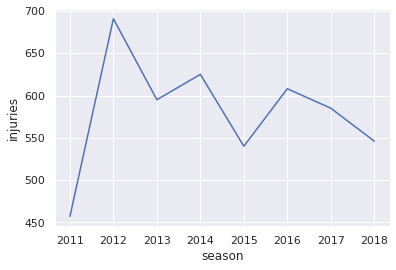

In [118]:
sns.lineplot(x = adj_seasonal_totals["season"], y = adj_seasonal_totals["injuries"])
plt.show()

It looks like, when adjusted for the number of games played, the lockout-shortened 2012 season had the most injuries by far. I want to investigate whether this difference is statistically significant. I can't use the adjusted totals -- if the null hypothesis that this difference is due to chance were true, then we would expect the missed 16 games of the season to be filled in with the mean injury rate across all seasons, not with the mean injury rate for 2012.

To account for this, I convert the 2012 number into "injuries per game" with a sample size of 66 and compare it to the mean injuries per game across the entire sample.

In [119]:
injuries_per_game = seasonal_totals["injuries"].sum() / (82 * 7 + 66)
print(injuries_per_game)
lockout_ipg = seasonal_totals["injuries"][1] / 66
print(lockout_ipg)

#6.89 without lockout year

7.05
8.424242424242424


def confidence_interval(data, =n = 66
dof = n-1
mean = 10.466
std = 

##Injuries Within Seasons

In [0]:
season_progressions = just_injuries.groupby(by = ["season", "binned_days"]).count()

In [121]:
season_progressions = season_progressions.reset_index()
season_progressions = season_progressions[["season", "binned_days", "date"]]
season_progressions.columns = ["season", "binned_days", "n_injuries"]

,season,binned_days,n_injuries
0,2011.0,0,19
1,2011.0,1,20
2,2011.0,2,24
3,2011.0,3,29
4,2011.0,4,35


In [0]:
lockout_progression = season_progressions[season_progressions["season"] == 2012]

In [0]:
def bin_seasons(season):
  if season in [2011, 2013, 2014, 2015, 2016, 2017, 2018]:
    return True
  else: 
    return False

non_lockouts = season_progressions[season_progressions["season"].apply(bin_seasons)]

In [156]:
non_lockouts.head()

,season,binned_days,n_injuries
0,2011.0,0,19
1,2011.0,1,20
2,2011.0,2,24
3,2011.0,3,29
4,2011.0,4,35


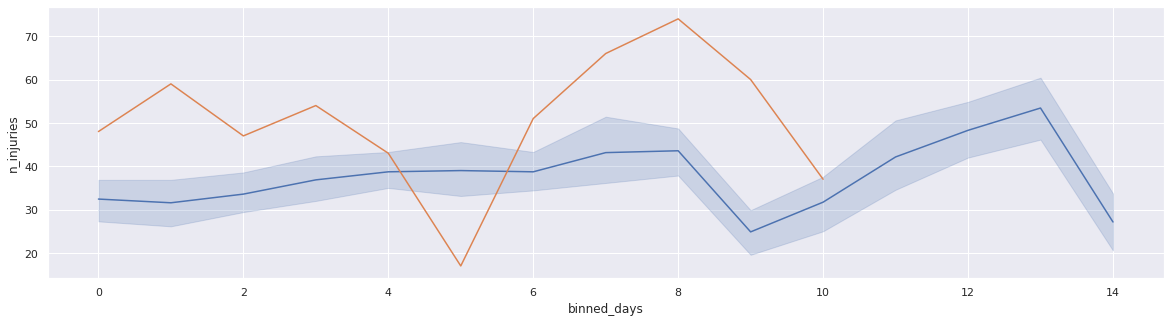

In [157]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(x = non_lockouts["binned_days"], y = non_lockouts["n_injuries"])
sns.lineplot(x = lockout_progression["binned_days"], y = lockout_progression["n_injuries"])
plt.show()

We can see from the confidence intervals surrounding the bins that there's a meaningful trend in injury increase between bin 1 and bin 8, then a decrease due to the All-Star break, which seems to temporarily reset injury rates. However, it only takes a few weeks for injury rates to go back up to their pre-ASB levels, which they then exceed.

##Analyzing Rest

In [124]:
rest_totals = pd.DataFrame(rest["season"].value_counts())
rest_totals = rest_totals.reset_index()
rest_totals.columns = ["season", "days of rest"]
rest_totals = rest_totals.sort_values(by = "season")
rest_totals = rest_totals.reset_index(drop = True)
rest_totals.iloc[1, 1] = round((rest_totals.iloc[1,1] * 82/66), 2)
rest_totals

,season,days of rest
0,2011.0,33.00
1,2012.0,89.45
2,2013.0,31.00
3,2014.0,61.00
4,2015.0,65.00
5,2016.0,108.00
6,2017.0,130.00
7,2018.0,42.00


In [0]:
merged_seasons = seasonal_totals.merge(rest_totals, on = "season")

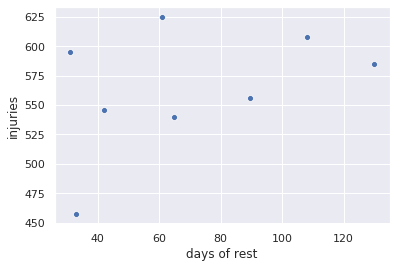

In [126]:
sns.scatterplot(x = merged_seasons["days of rest"], y = merged_seasons["injuries"])
plt.show()

In [127]:
 #drop 2012 
binned_day_totals = pd.DataFrame(just_injuries["binned_days"].value_counts())
binned_day_totals = binned_day_totals.reset_index()
binned_day_totals.columns = ["bin", "injuries"]
binned_day_totals = binned_day_totals.sort_values(by = "bin")
binned_day_totals = binned_day_totals.reset_index(drop = True)
binned_day_totals = binned_day_totals.drop(index = 14)
binned_day_totals

# check for ASB, end of season. perhaps drop last row. check for statistical significance.

,bin,injuries
0,0,275
1,1,280
2,2,282
3,3,312
4,4,314
5,5,290
6,6,322
7,7,368
8,8,379
9,9,234


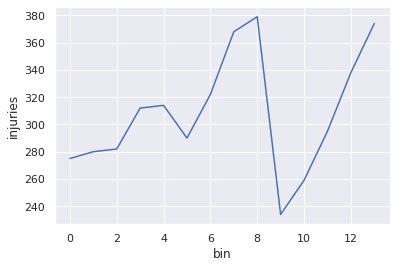

In [128]:
sns.lineplot(x = binned_day_totals["bin"], y = binned_day_totals["injuries"])
plt.show()

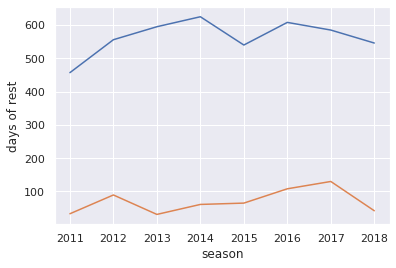

In [129]:
sns.set()
sns.lineplot(x = seasonal_totals["season"], y = seasonal_totals["injuries"])
sns.lineplot(x = rest_totals["season"], y = rest_totals["days of rest"])
plt.show()

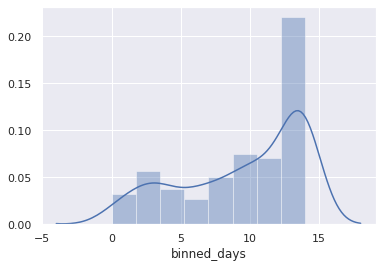

In [130]:
sns.distplot(rest["binned_days"])
plt.show()
# Plots - add markdown explaining what to look for in the plot (whether interesting or unremarkable)

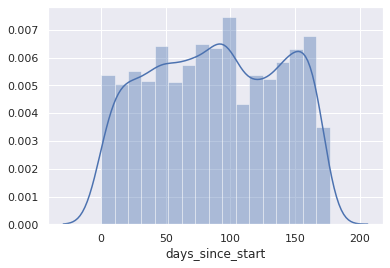

In [131]:
sns.distplot(just_injuries["days_since_start"])

In [132]:
rest_totals = pd.DataFrame(rest["season"].value_counts())
rest_totals = rest_totals.reset_index()
rest_totals.columns = ["season", "days of rest"]
rest_totals = rest_totals.sort_values(by = "season")
rest_totals = rest_totals.reset_index(drop = True)
rest_totals.iloc[1, 1] = round((rest_totals.iloc[1,1] * 82/66), 2)
rest_totals

,season,days of rest
0,2011.0,33.00
1,2012.0,89.45
2,2013.0,31.00
3,2014.0,61.00
4,2015.0,65.00
5,2016.0,108.00
6,2017.0,130.00
7,2018.0,42.00


In [0]:
rest_teams = pd.DataFrame(rest["team"].value_counts()).reset_index()
rest_teams.columns = ["team", "days of rest"]

In [134]:
rest_teams.head(30)

,team,days of rest
0,Spurs,84
1,Kings,37
2,Mavericks,32
3,Hawks,31
4,Cavaliers,29
5,Grizzlies,27
6,76ers,25
7,Nets,25
8,Celtics,22
9,Clippers,20


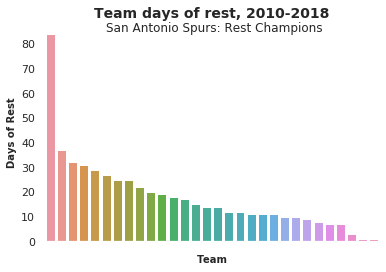

In [135]:
fig, ax = plt.subplots()
ax.set(facecolor = "white")
fig.patch.set(facecolor = "white")
sns.barplot(x = rest_teams["team"], y = rest_teams["days of rest"])

ax.set_xticklabels("")
ax.set_xlabel("Team", fontweight = "bold", fontsize = 10)
ax.set_ylabel("Days of Rest", fontweight = "bold", fontsize = 10)
ax.text(s = "San Antonio Spurs: Rest Champions", x = 5, y = 85, fontsize = 12)
ax.set_title("Team days of rest, 2010-2018", fontweight="bold", fontsize = 14)

plt.show()

In [136]:
rest["player"].value_counts().head(10)

Emanuel Ginobili / Manu Ginobili    20
Tim Duncan                          19
Kevin Garnett                       17
(William) Tony Parker               16
Rajon Rondo                         16
LeBron James                        15
Chandler Parsons                    12
Joel Embiid                         12
Eric Gordon                         10
LaMarcus Aldridge                    9
Name: player, dtype: int64

As you might expect, the leaderboard for individuals is dominated by Spurs, with the Spurs' "big three" -- Manu Ginobili, Tim Duncan, and Tony Parker -- all in the top five. Teams competing for a title, as with the Spurs and the Celtics (Kevin Garnett, Rajon Rondo, and Paul Pierce) may consider the regular season less important than the playoffs, although, as the Spurs have shown, rest doesn't necessarily come at the expense of regular-season success.

##Teams and Injuries

In [0]:
injury_teams = pd.DataFrame(just_injuries["team"].value_counts()).reset_index()
injury_teams.columns = ["team", "injuries"]
injury_teams = injury_teams.drop(index = 30)

In [145]:
print(injury_teams["injuries"].mean())
injury_teams.head()

150.36666666666667


,team,injuries
0,76ers,205
1,Bucks,204
2,Nuggets,189
3,Rockets,186
4,Pelicans,181


In [143]:
injury_teams.tail()

,team,injuries
25,Blazers,109
26,Mavericks,109
27,Pistons,107
28,Pacers,102
29,Thunder,66


In [0]:
team_data = injury_teams.merge(rest_teams, on = "team")

In [146]:
np.corrcoef(team_data["injuries"], team_data["days of rest"])

array([[1.        , 0.00288544],
       [0.00288544, 1.        ]])

There's almost zero correlation between total days of rest and total injuries. However, this is likely an artifact both of underlying variables and of our data set -- oft-injured players are more likely to get rested, and teams might label intended rest days as minor injuries. The best evidence that there's a relationship between rest and injury rate comes from observation: NBA teams, with millions of dollars in labor productivity at stake, have almost universally adopted the Spurs' style of giving players occasional rest day to keep them in peak condition.

#Conclusions